In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import arviz as az
import pymc3 as pm
import theano.tensor as tt
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [2]:
# Read the data
howell1 = pd.read_csv('../Data/Howell1.csv',sep=';')

# Normalize the age column
howell1['age'] = StandardScaler().fit_transform(howell1['age'].values.reshape(-1,1))

# Divide dataframe into two equal
d1, d2 = train_test_split(howell1, test_size=0.5, random_state=42)

In [3]:
d1.describe()

,height,weight,age,male
count,272.000000,272.000000,272.000000,272.000000
mean,139.846248,36.518423,-0.007330,0.459559
std,26.206521,14.259042,0.981193,0.499280
min,55.880000,4.847764,-1.415702,0.000000
25%,130.340100,24.408919,-0.788525,0.000000
50%,149.225000,41.276872,-0.161348,0.000000
75%,157.638750,47.520849,0.610562,1.000000
max,172.999400,58.825212,2.829802,1.000000


## Polynomial models

In [4]:
from sklearn.preprocessing import PolynomialFeatures
import pickle

def pickle_model(output_path: str, model, trace):
    """Pickles PyMC3 model and trace"""
    with open(output_path, "wb") as buff:
        pickle.dump({"model": model, "trace": trace}, buff)
        
def sample_polynomial_regressions(d1, xcol, ycol, degree=1):

    yval = d1[ycol].values
    # Polynomial features
    polynomial_features= PolynomialFeatures(degree=degree, include_bias=False)
    xval = polynomial_features.fit_transform(d1[xcol].values.reshape(-1,1))
    
    with pm.Model() as model_1:
        a = pm.Normal('a', mu=10, sigma=10)
        b = pm.Normal('b', mu=0, sigma=1,shape=(degree))
        sigma = pm.Uniform('sigma', lower=0, upper=10)
        mu = pm.Deterministic('mu', a + tt.dot(xval,b))
        h = pm.Normal('h', mu=mu, sigma=sigma, observed=yval)
        trace_1 = pm.sample(cores=2)
    
    pickle_model('polynomial_model_degree_%d.pkl' % degree, model_1, trace_1)
    return model_1,trace_1

In [5]:
M1,trace1 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=1)
M2,trace2 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=2)
M3,trace3 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=3)
M4,trace4 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=4)
M5,trace5 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=5)
M6,trace6 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=6)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 899.16draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:18<00:00, 106.52draws/s]
The acceptance probability does not match the target. It is 0.8920864956271821, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:12<00:00, 166.25draws/s]
The acceptance probability does not match the target. It is 0.8814156733070779,

**Widely Applicable Information Criterion (WAIC):** It does not require a multivariate Gaussian posterior, and it is often more accurate than DIC. The distinguishing feature of WAIC is that it is pointwise. It access flexibility of a model with respect to fitting each observation, and then sumps up across all observations.

$WAIC = -2 (\sum_{i=1}^N \log Pr(y_i) - \sum_{i=1}^N V(y_i))$

Where $V(y_i)$ is the variance in the log-likelihood for observation $i$ in the training sample.

http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf

logpdf will be imported from stats package. </br>

$p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }} e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} }$

$log(p(x)) = -0.5*log{2 \pi \sigma^2} - \frac{ (x - \mu)^2 } {2 \sigma^2}$

From WAIC definition (compute for each $y_i$ or weigth data):

$\log Pr(y_i) = -0.5*log{2 \pi \sigma^2} - \frac{ (y_i - \mu_i)^2 } {2 \sigma^2}

In [6]:
from scipy.stats import norm
from scipy.special import logsumexp

In [7]:
def compute_WAIC_general(d1,trace):
    
    #yi
    yi = d1['height'].values

    # mu
    degree = trace['b'].shape[1]
    polynomial_features= PolynomialFeatures(degree=degree, include_bias=False)
    xi = polynomial_features.fit_transform(d1['age'].values.reshape(-1,1))
    a = trace['a'][:,np.newaxis]
    b = trace['b']
    mu = a + np.dot(b,xi.T)
    
    #sigma
    sigma = trace['sigma'] 
    
    # Make a nsamples X nobs log-liklihoods matrix
    loglik = np.zeros(mu.shape)
    nsamples = mu.shape[0]
    nobs = mu.shape[1]
    for i in range(nsamples):
        loglik[i,:] = norm.logpdf(yi.ravel(), loc=mu[i,:].ravel(), scale=sigma[i])
    
    # compute lppd
    lppd = np.zeros((nobs,1))
    for i in range(nobs):
        lppd[i] = logsumexp(loglik[:,i]) - np.log(nsamples)
    
    # computing pwaic
    pwaic = np.zeros((nobs,1))
    for i in range(nobs):
        pwaic[i] = np.var(loglik[:,i])
    
    # finally compute WAIC
    waic = -2*(np.sum(lppd) - np.sum(pwaic))
    return waic

def compare_models_waic(waic):
    
    df_waic = pd.DataFrame.from_dict(waic, orient='index')
    df_waic.columns = ['WAIC']
    df_waic['dWAIC'] = df_waic['WAIC'] - df_waic['WAIC'].min()
    df_waic = df_waic.sort_values(by='dWAIC')

    df_waic['weight'] = np.exp(-0.5*df_waic['dWAIC'])
    df_waic['weight'] = df_waic['weight']/df_waic['weight'].sum()
    return df_waic

In [9]:
# test-sample Deviance in d2
waic_d2 = {'M1':compute_WAIC_general(d2,trace1),
       'M2':compute_WAIC_general(d2,trace2),
       'M3':compute_WAIC_general(d2,trace3),
       'M4':compute_WAIC_general(d2,trace4),
       'M5':compute_WAIC_general(d2,trace5),
       'M6':compute_WAIC_general(d2,trace6)}
df_waic_d2 = compare_models_waic(waic_d2)
df_waic_d2

,WAIC,dWAIC,weight
M5,1975.307770,0.000000,9.944730e-01
M6,1985.692900,10.385129,5.527017e-03
M4,2065.593117,90.285347,2.468193e-20
M3,2204.453265,229.145495,1.734926e-50
M2,2501.324803,526.017033,5.949022e-115
M1,3073.656177,1098.348407,3.120806e-239


In [8]:
# Deviance in d1
waic_d1 = {'M1':compute_WAIC_general(d1,trace1),
       'M2':compute_WAIC_general(d1,trace2),
       'M3':compute_WAIC_general(d1,trace3),
       'M4':compute_WAIC_general(d1,trace4),
       'M5':compute_WAIC_general(d1,trace5),
       'M6':compute_WAIC_general(d1,trace6)}
df_waic_d1 = compare_models_waic(waic_d1)
df_waic_d1

,WAIC,dWAIC,weight
M5,1968.772168,0.000000,9.083531e-01
M6,1973.359548,4.587381,9.164688e-02
M4,2029.390863,60.618696,6.238386e-14
M3,2133.274140,164.501972,1.726256e-36
M2,2377.114456,408.342288,1.940231e-89
M1,2861.238013,892.465845,1.451305e-194


## Compare the WAIC estimates from d1 and d2

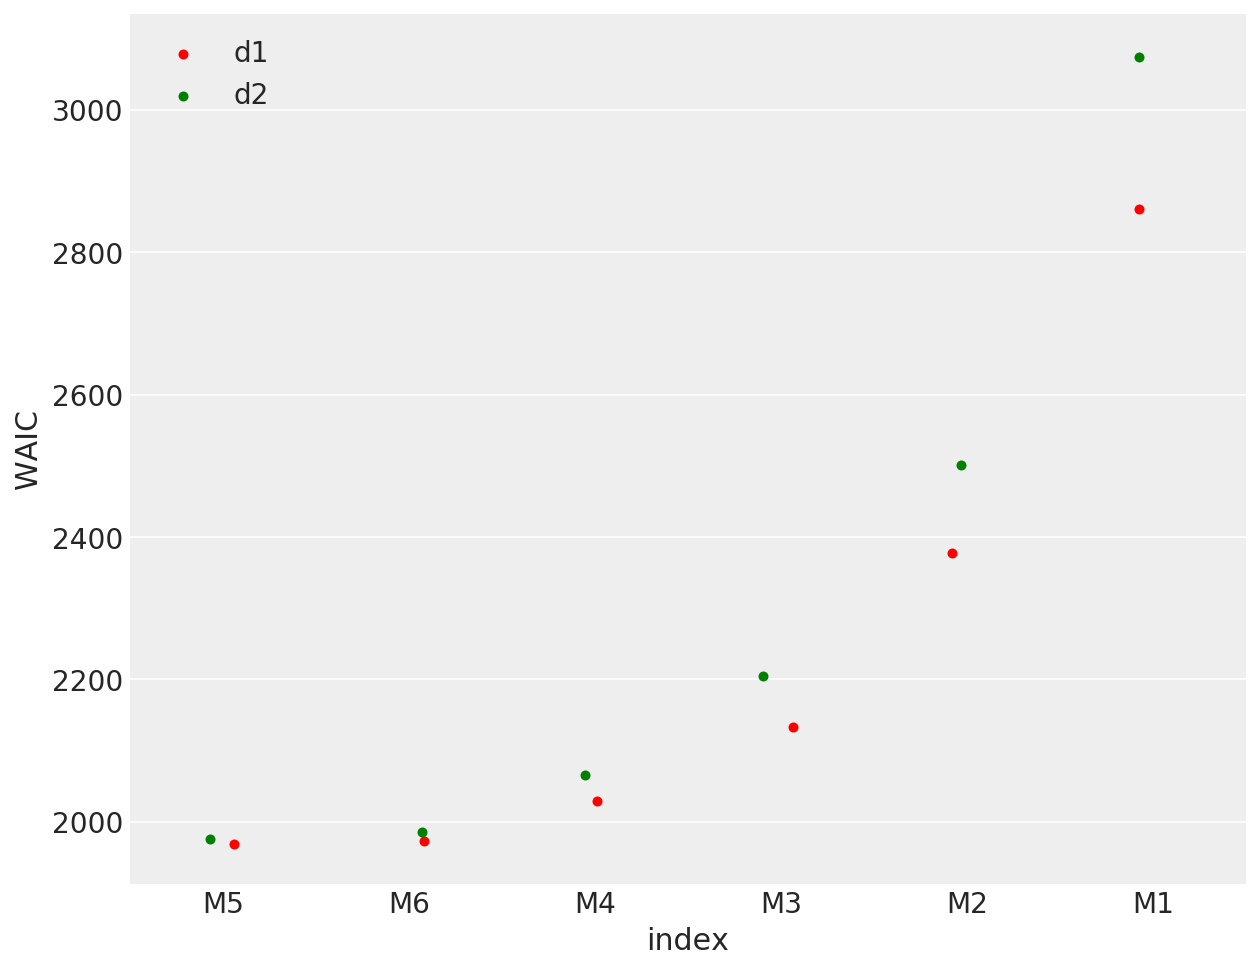

In [38]:
fig,ax = plt.subplots(figsize=(10,8))
g=sns.catplot(y='WAIC',data=df_waic_d1.reset_index(),x='index',label='d1',ax=ax,color='r')
h=sns.catplot(y='WAIC',data=df_waic_d2.reset_index(),x='index',label='d2',ax=ax,color='g')
plt.close(g.fig)
plt.close(h.fig)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[5:7], labels[5:7])

## Conclusion: WAIC does a pretty good job in estimating the test deviance. The model ordering is exactly the same!!